# Explore the meta-data

This will be pretty brief given time restrictions. However, if any of the meta data showed 
an interesting relationship with the output variable it could be used in the model. 
Categorical variables could be converted into embeddings and then these values
could be concatenated at some point in the Unet with the visual information.

A more interesting way to do this EDA analysis would be to look at correlations between this metadata and features such 
as the location of region of interest, size of region of interest, shape of region of interest, etc. This size of the region 
could be extracted using the number of class=1 pixels and the pixel spacing variable in the meta data. 


In [6]:
#!pip install pydicom


In [27]:

import cv2
import sys
import matplotlib.pylab as plt
import pandas as pd
from pathlib import Path
import numpy as np
import glob

SRC_FILES = '/home/ec2-user/SageMaker/seg_project/src'
sys.path.append(SRC_FILES)
from vis import visualize
from preprocessing import read_dicom_file

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# Location of png files
MASK_DIR = '/home/ec2-user/SageMaker/seg_project/data/preprocessed_data/train-masks/size-512/'
TRAIN_DIR = '/home/ec2-user/SageMaker/seg_project/data/preprocessed_data/train/size-512/'
META_DATA_DIR = '/home/ec2-user/SageMaker/seg_project/data/meta_data_siim.csv'

# class labels
CLASSES = ['no-region', 'single-region', 'multiple-regions']


In [48]:

def plot_example_idx(idx, mask_dir, img_dir, meta_data_df):
    print(meta_data_df.loc[idx])
    name = meta_data_df.loc[idx].file_name
    img = cv2.imread(img_dir + name + '.png', 1)
    mask = cv2.imread(mask_dir + name + '.png', 0)
    _ = visualize(img, mask)
    plt.show()
    return img, mask

def find_dicom_version(path, dicom_dir):
    search = dicom_dir + '*/*/'+ path + '.dcm'
    return glob.glob(search)


In [30]:

meta_data_df = pd.read_csv(META_DATA_DIR, index_col=0)
meta_data_df.head()


PatientAge                             PatientID PatientSex  \
0          38  17d405a3-a0d2-4901-b33a-63906aa48d9f          M   
1          10  8ab1ffda-8b65-4914-95d6-2e549e328666          F   
2          50  bfef51d3-6541-4792-bac1-d21d41ee60fd          F   
3          68  d19d956f-4ddd-4688-81ff-909c85e0e2d9          F   
4          65  cf71a760-f693-4ccf-acd4-a41ff4845a5f          M   

   PatientOrientation ViewPosition      label  train_set  \
0                 NaN           PA  no-region       True   
1                 NaN           AP  no-region       True   
2                 NaN           AP  no-region       True   
3                 NaN           AP  no-region       True   
4                 NaN           AP  no-region       True   

                                           file_name  
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...  
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...  
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...  
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...  
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...


If there are patients with multiple scans we need to be careful when constructing
the train and validation sets -- we would need to split the sets by patients.



In [43]:
# Looks there there is only a single img per patient
# Note, the preprocessing writes files based on the imageid
# so may remove muliple scans from a single patient automatically.

meta_data_df.groupby('PatientID').count()['file_name'].max()


1


## Prevalance with Age


In [14]:
# There seems to be some error in the meta data and there is a patient who is 400 years old!
meta_data_df.PatientAge.max()


413

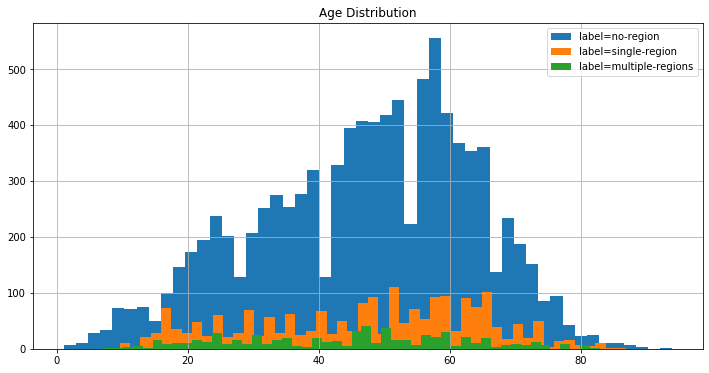

In [56]:
# The only clear difference in age is that pneumothorax seems uncommon in people less than 10
# Otherwise, the distributions look similar.

meta_data_df = meta_data_df[meta_data_df.PatientAge < 100]

for class_name in classes:
    tmp_df = meta_data_df[meta_data_df.label == class_name]
    tmp_df.PatientAge.hist(bins=50, figsize=(12,6), label=f'label={class_name}')
    plt.title('Age Distribution');
plt.legend()



## Prevalance with Sex

In [69]:

meta_data_df.groupby(by=['PatientSex', 'label']).count()


PatientAge  PatientID  PatientOrientation  \
PatientSex label                                                         
F          multiple-regions         265        265                   0   
           no-region               4258       4258                   0   
           single-region            915        915                   0   
M          multiple-regions         359        359                   0   
           no-region               5160       5160                   0   
           single-region           1130       1130                   0   

                             ViewPosition  train_set  file_name  
PatientSex label                                                 
F          multiple-regions           265        265        265  
           no-region                 4258       4258       4258  
           single-region              915        915        915  
M          multiple-regions           359        359        359  
           no-region                 5160       5160       5160  
           single-region             1130       1130       1130


# Inspect the image and masks for each class type



It can be very helpful to get a sense for what the relevant class actually looks like. 
This can help diagnose potential issues etc. However, unfortunately, in this case the pneumothorax
is quite hard to identify (at least for me).

There are a lot of image artifacts (top write corner) and the medical equipment is very clearly visible 
in a number of images.


Index = 6446
PatientAge                                                           24
PatientID                          4f6f1b9c-2f4f-45d6-8adc-e7aaeecda706
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         AP
label                                                     single-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.2877.151787517...
Name: 6446, dtype: object


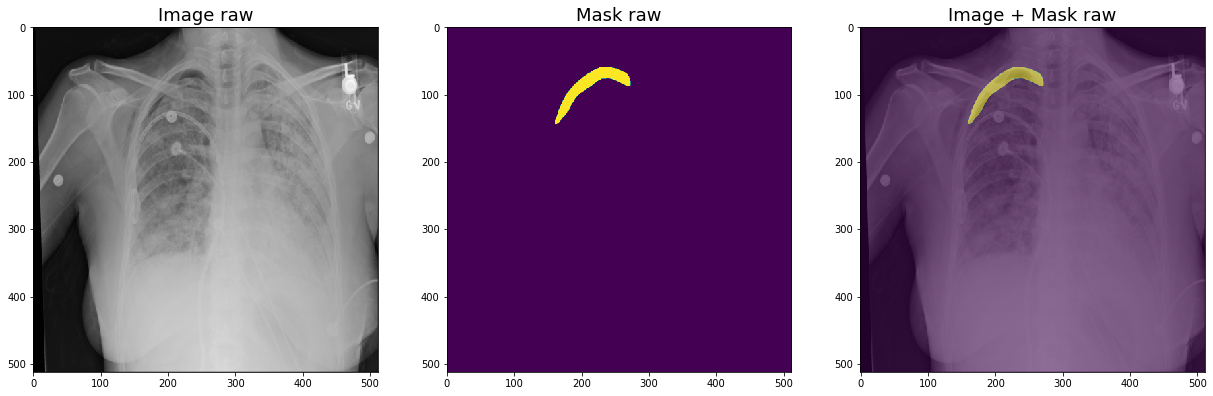

Index = 8467
PatientAge                                                           31
PatientID                          3b5281c1-b2a3-42a4-9c23-2c8d3339a37f
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                     single-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.3747.151787517...
Name: 8467, dtype: object


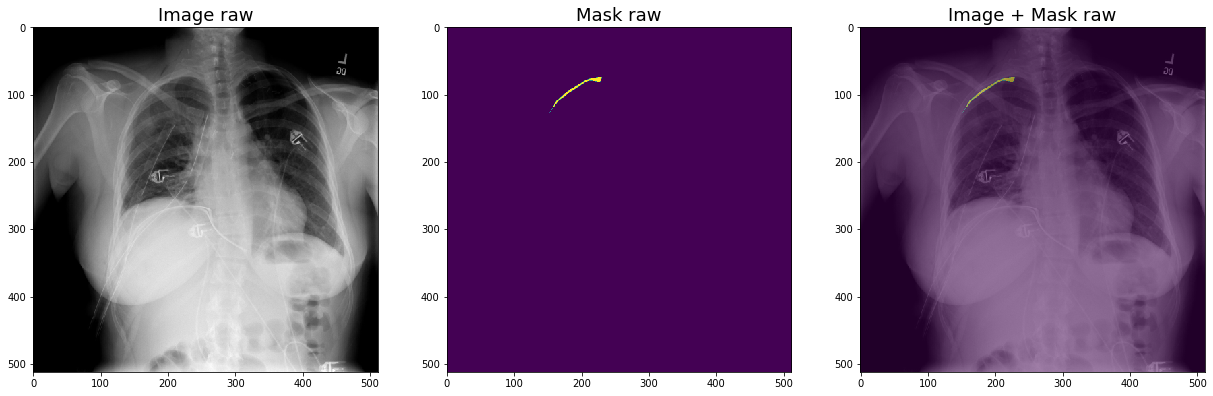

Index = 5227
PatientAge                                                           43
PatientID                          95caeaec-c714-4be1-9575-d18e145ecea6
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         AP
label                                                     single-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.1647.151787516...
Name: 5227, dtype: object


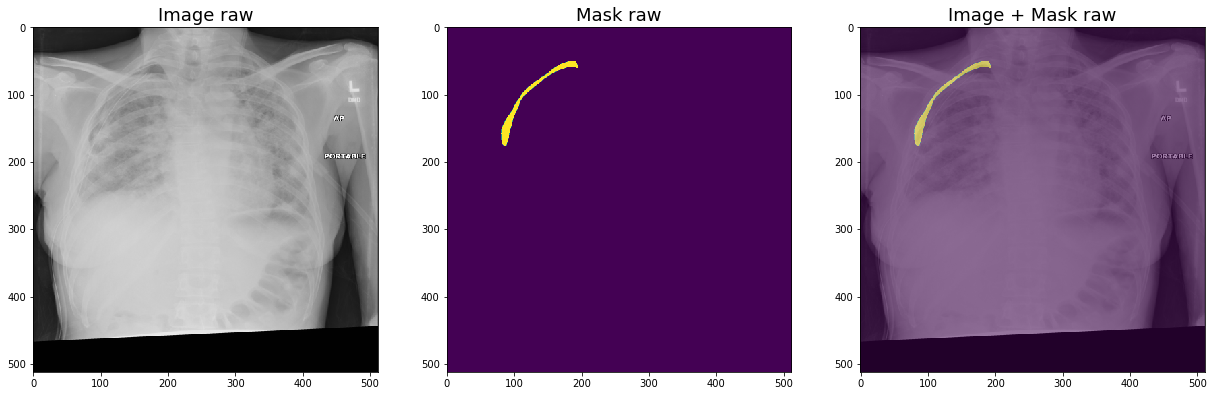

Index = 7481
PatientAge                                                           52
PatientID                          2e74e637-051b-43d2-8e2d-0986a4d717d1
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         AP
label                                                     single-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.32334.15178751...
Name: 7481, dtype: object


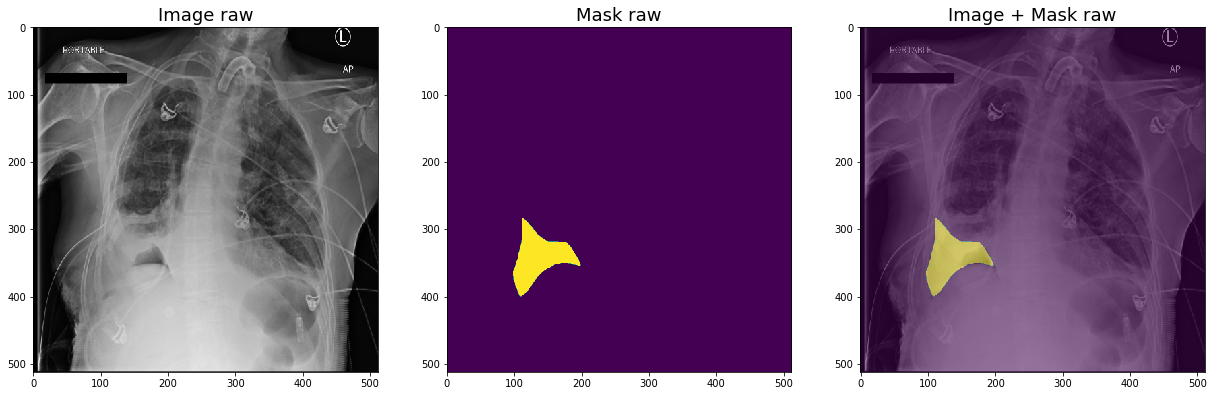

Index = 11381
PatientAge                                                           62
PatientID                          5d97213a-b8bb-4c8e-a867-e59fed0069aa
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                     single-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.6409.151787519...
Name: 11381, dtype: object


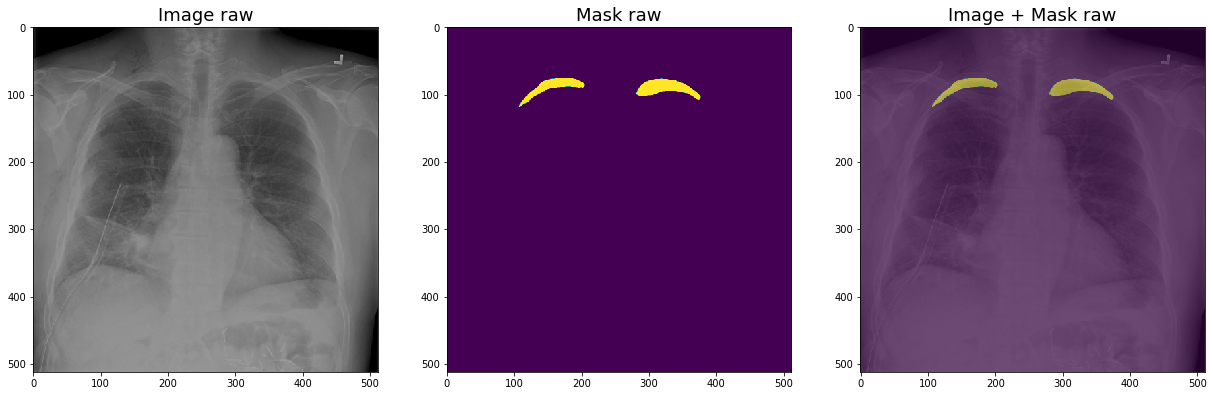

In [49]:

single_region_cases = meta_data_df[meta_data_df.label == 'single-region'].index.values
for ix in np.random.choice(single_region_cases, 5):
    print(f'Index = {ix}')
    _, _ = plot_example_idx(ix, MASK_DIR, TRAIN_DIR, meta_data_df)


PatientAge                                                           65
PatientID                          d99d7fbd-8481-4321-830f-de18c84eb488
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                  multiple-regions
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.4231.151787518...
Name: 8997, dtype: object


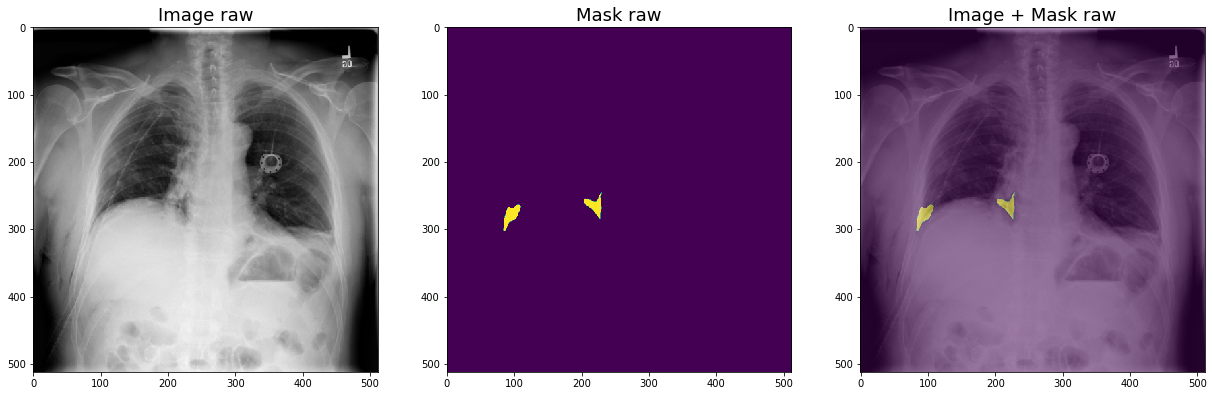

PatientAge                                                           45
PatientID                          8efed7ef-023b-4238-943c-834d7b0a524b
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                  multiple-regions
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.5373.151787518...
Name: 10248, dtype: object


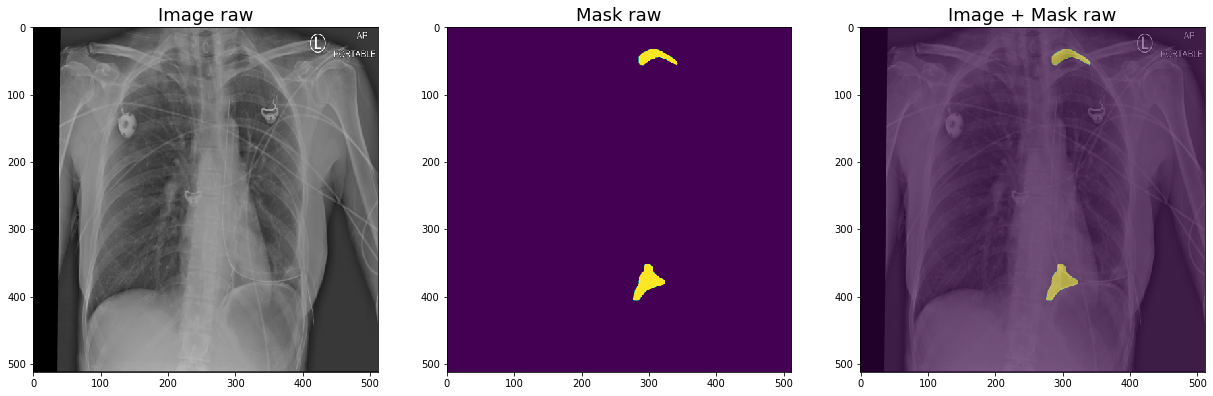

PatientAge                                                           63
PatientID                          f2397fcb-a3a1-41f7-94bd-dcaa7a0c4824
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                  multiple-regions
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.12982.15178752...
Name: 3259, dtype: object


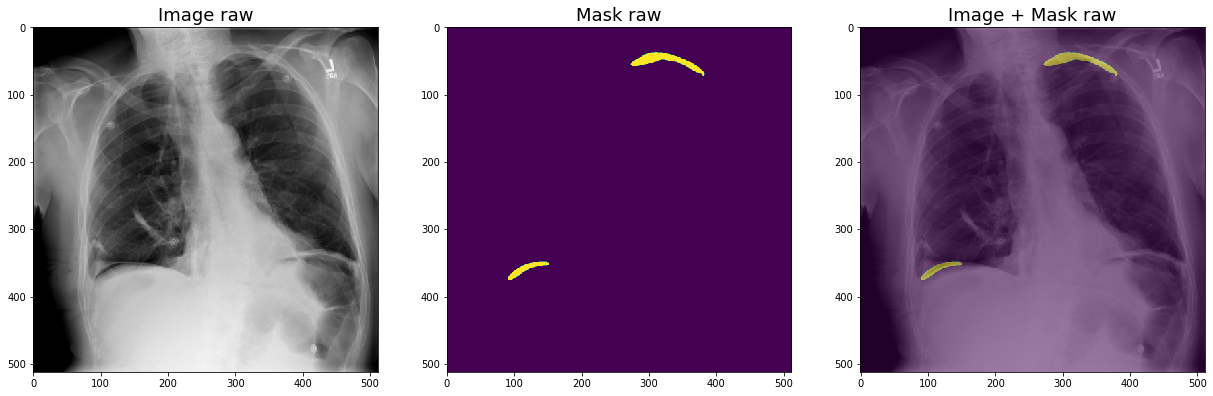

PatientAge                                                           70
PatientID                          867f3480-8ca8-4281-85fd-cffa653845fc
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                  multiple-regions
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.2239.151787517...
Name: 5817, dtype: object


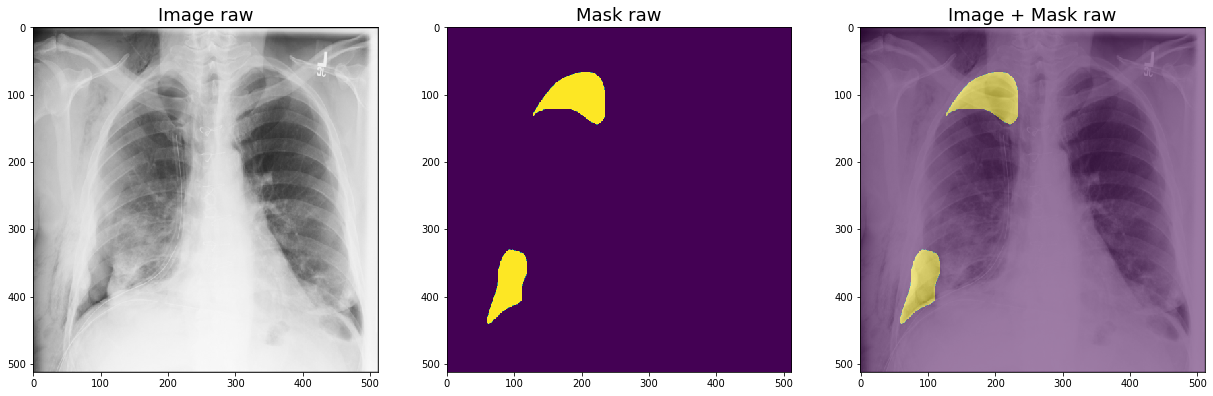

PatientAge                                                           60
PatientID                          ce384716-2d38-487d-9714-e2d9091fce31
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                  multiple-regions
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.10841.15178752...
Name: 921, dtype: object


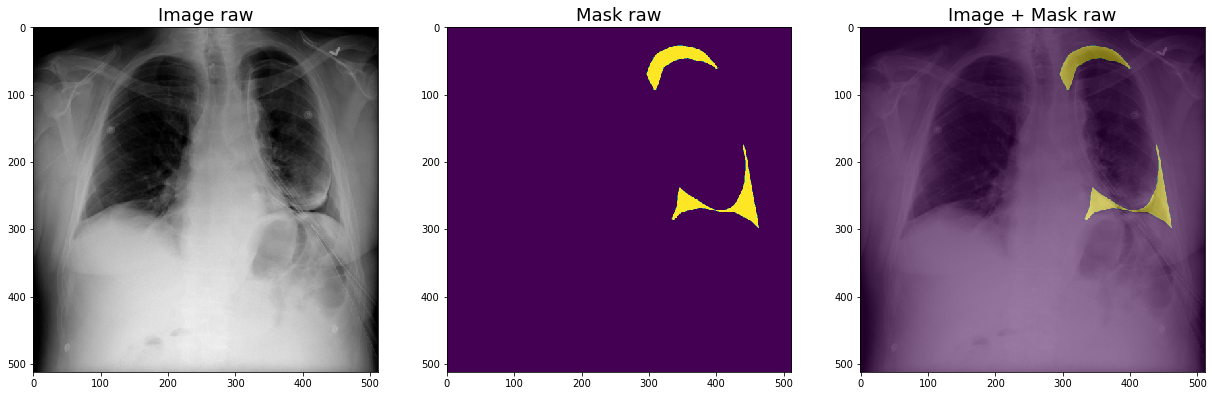

In [50]:

multiple_region_cases = meta_data_df[meta_data_df.label == 'multiple-regions'].index.values
for ix in np.random.choice(multiple_region_cases, 5):
    _, _ = explore_idx(ix, MASK_DIR, TRAIN_DIR, meta_data_df)


PatientAge                                                           29
PatientID                          25ecbb05-ef80-417d-a943-d19d35e7561d
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                         no-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.5465.151787518...
Name: 10349, dtype: object


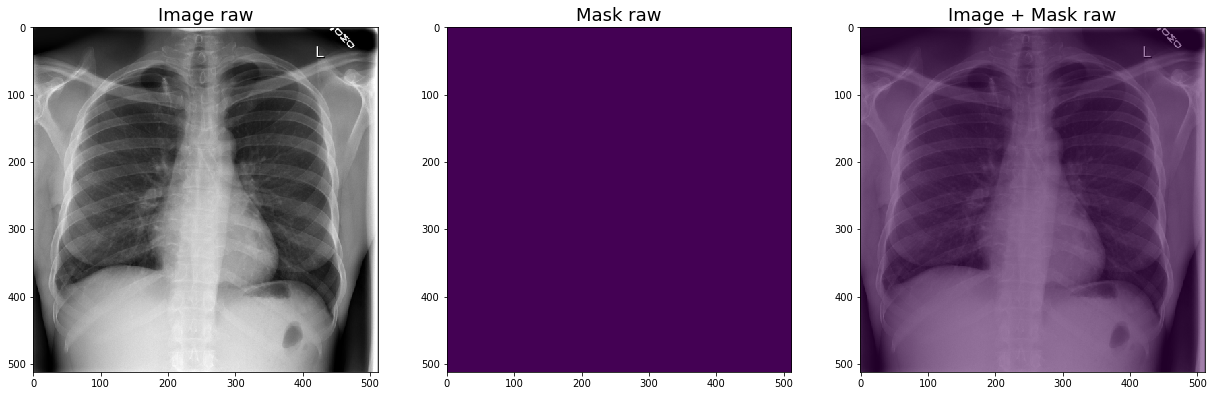

PatientAge                                                           18
PatientID                          d0ec4ddb-3d84-4698-8e10-a3bc8ac9f074
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                         no-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.10212.15178752...
Name: 231, dtype: object


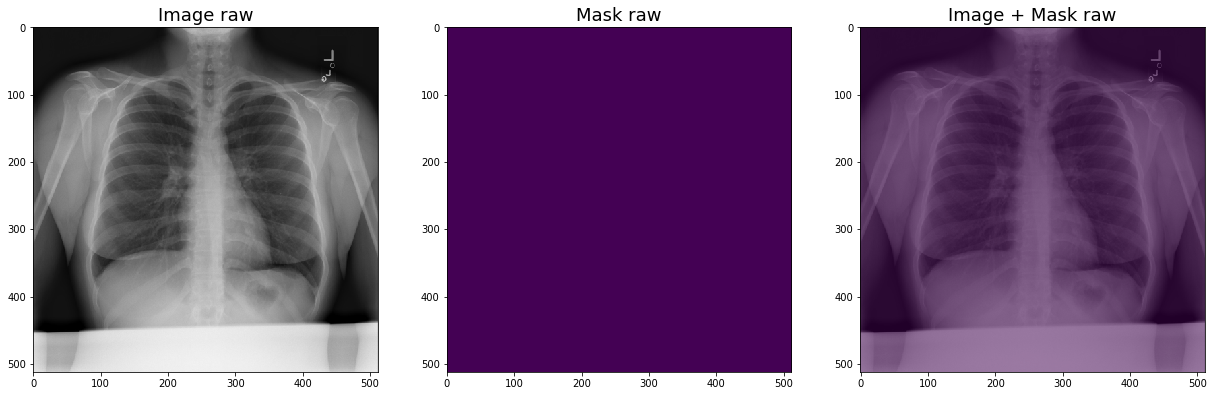

PatientAge                                                           24
PatientID                          05a50dfe-cea7-49a6-b172-2f581b4cc0a0
PatientSex                                                            F
PatientOrientation                                                  NaN
ViewPosition                                                         AP
label                                                         no-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.6959.151787520...
Name: 11985, dtype: object


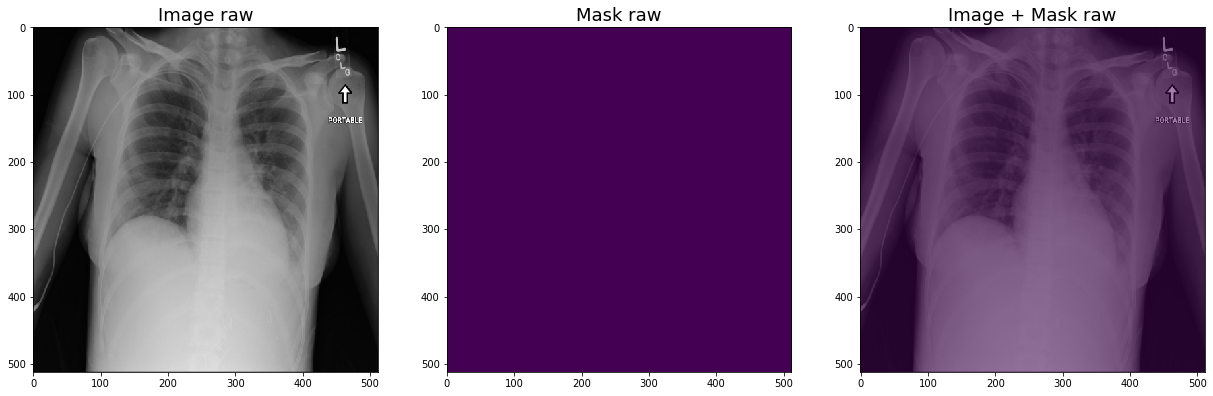

PatientAge                                                            5
PatientID                          2c2778ef-a1f6-438e-abae-d3cffb733e98
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         PA
label                                                         no-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.4375.151787518...
Name: 9155, dtype: object


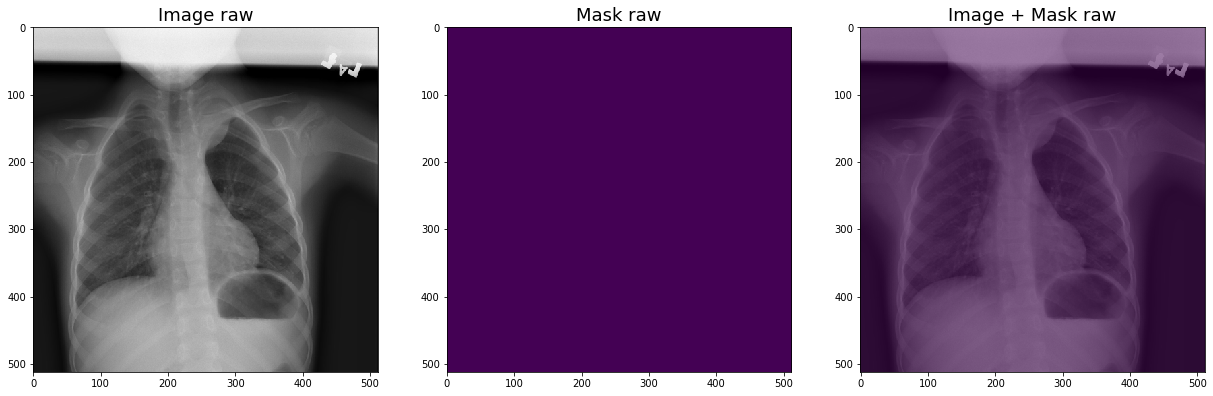

PatientAge                                                           58
PatientID                          8a7e4925-eb55-44fe-8494-3c7018c1594f
PatientSex                                                            M
PatientOrientation                                                  NaN
ViewPosition                                                         AP
label                                                         no-region
train_set                                                          True
file_name             1.2.276.0.7230010.3.1.4.8323329.12888.15178752...
Name: 3156, dtype: object


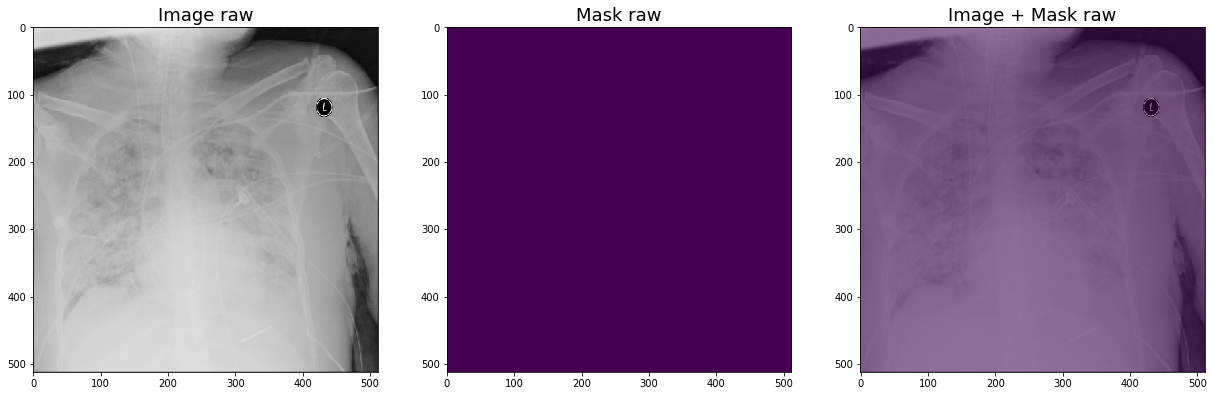

In [51]:

negative_cases = meta_data_df[meta_data_df.label == 'no-region'].index.values
for ix in np.random.choice(negative_cases, 5):
    _, _ = explore_idx(ix, MASK_DIR, TRAIN_DIR, meta_data_df)
    